In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product
from python_scripts.sarima_helper import predict_with_windows
import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [3]:
df = df.resample('D').ffill()


<AxesSubplot:xlabel='Date'>

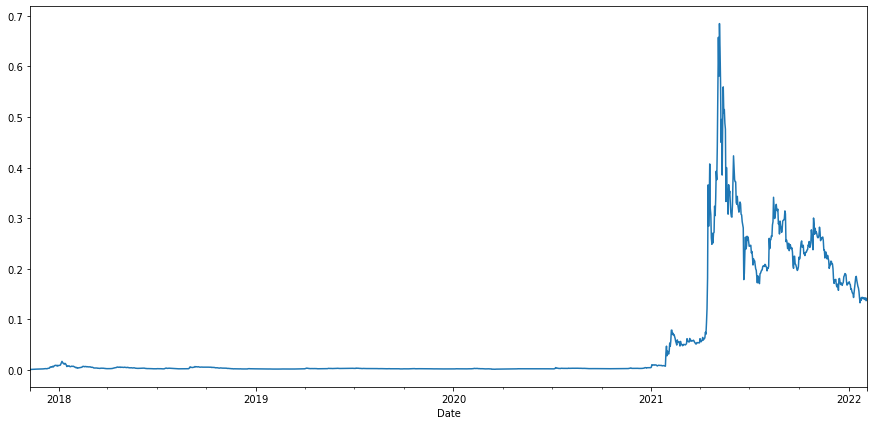

In [4]:
df.Close.plot(figsize=(15, 7))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Freq: D
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   Open                         1549 non-null   float64       
 2   High                         1549 non-null   float64       
 3   Low                          1549 non-null   float64       
 4   Close                        1549 non-null   float64       
 5   Adj Close                    1549 non-null   float64       
 6   Volume                       1549 non-null   int64         
 7   twitter_followers            1549 non-null   float64       
 8   reddit_average_posts_48h     1549 non-null   float64       
 9   reddit_average_comments_48h  1549 non-null   float64       
 10  reddit_subscribers           1549 non-null   float64       
 11  reddit_accounts_a

In [6]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
window1 = 7
window2 = 14
window3 = 30
window4 = 3
window5 = 21
window6 = 60
'''
df_rolled_7d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_14d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
df_rolled_3d = df[lag_features].rolling(window=window4, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_14d = df_rolled_14d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_14d = df_rolled_14d.std().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)
'''

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df[feature].shift(window1)
    df[f"{feature}_mean_lag{window2}"] = df[feature].shift(window2)
    df[f"{feature}_mean_lag{window3}"] = df[feature].shift(window3)
    df[f"{feature}_mean_lag{window4}"] = df[feature].shift(window4)
    df[f"{feature}_mean_lag{window5}"] = df[feature].shift(window5)
    df[f"{feature}_mean_lag{window6}"] = df[feature].shift(window6)

    '''
    df[f"{feature}_mean_lag{window1}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_14d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window4}"] = df_mean_3d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_14d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window4}"] = df_std_3d[feature]
    '''
df.fillna(df.mean(), inplace=True)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,dogecoin_monthly_mean_lag30,dogecoin_monthly_mean_lag3,dogecoin_monthly_mean_lag21,dogecoin_monthly_mean_lag60,dogecoin_mean_lag7,dogecoin_mean_lag14,dogecoin_mean_lag30,dogecoin_mean_lag3,dogecoin_mean_lag21,dogecoin_mean_lag60
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,4.710994,4.727684,4.72055,4.699127,1.96561,1.964534,1.960362,1.965091,1.96377,1.964278
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,4.710994,4.727684,4.72055,4.699127,1.96561,1.964534,1.960362,1.965091,1.96377,1.964278
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,4.710994,4.727684,4.72055,4.699127,1.96561,1.964534,1.960362,1.965091,1.96377,1.964278
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,4.710994,1.000000,4.72055,4.699127,1.96561,1.964534,1.960362,0.570000,1.96377,1.964278
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,4.710994,1.000000,4.72055,4.699127,1.96561,1.964534,1.960362,0.240000,1.96377,1.964278


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Columns: 138 entries, Date to dogecoin_mean_lag60
dtypes: datetime64[ns](1), float64(135), int64(2)
memory usage: 1.6 MB


In [8]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7660.291, Time=8.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6119.341, Time=5.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7612.118, Time=5.82 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6783.917, Time=6.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2578.134, Time=4.96 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7618.425, Time=7.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4881.584, Time=6.74 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7663.825, Time=8.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7607.347, Time=7.92 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-7690.139, Time=8.78 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-7679.822, Time=8.34 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-7713.640, Time=11.04 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-7694.210, Time=9.89 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-4673.618, Time=11.17 sec
 ARIMA(4,0,3)(0,0,

<AxesSubplot:xlabel='Date'>

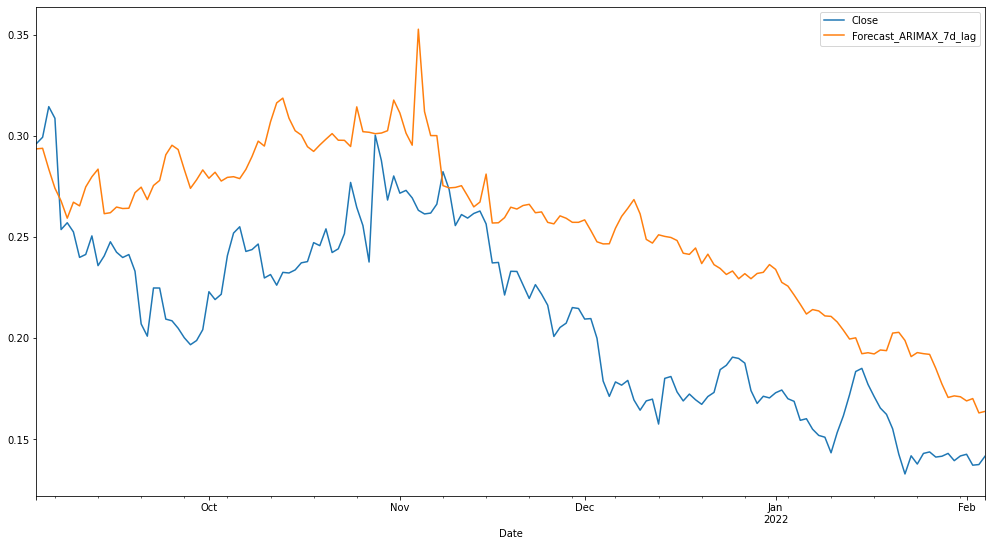

In [9]:
from pmdarima import auto_arima

#Pokusavam predikciju nad lagom od 7 dana
exog_7_days = []
for feature in lag_features:
    exog_7_days.append(f"{feature}_mean_lag{window1}")
    #exog_7_days.append(f"{feature}_std_lag{window1}")

model = auto_arima(train.Close, exogenous=train[exog_7_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_7_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_7_days])
test["Forecast_ARIMAX_7d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_7d_lag"]].plot(figsize=(17, 9))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7127.206, Time=7.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5909.509, Time=5.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7119.204, Time=5.46 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6555.714, Time=6.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2787.967, Time=5.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7132.097, Time=7.76 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6569.174, Time=7.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7134.592, Time=6.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7129.145, Time=6.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7134.197, Time=6.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7136.645, Time=5.95 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6557.715, Time=5.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7121.223, Time=5.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7131.237, Time=6.15 sec
 ARIMA(1,0,2)(0,0,0)

<AxesSubplot:xlabel='Date'>

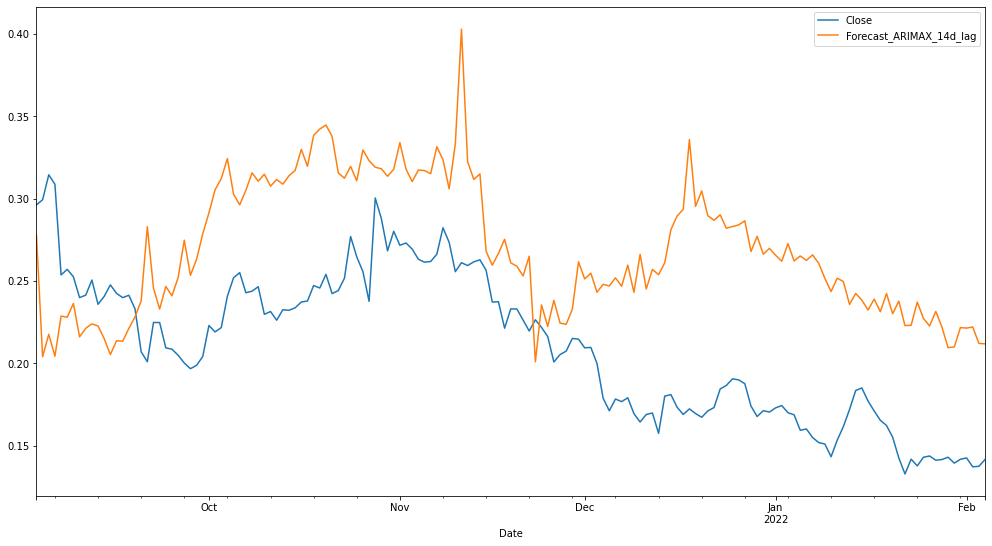

In [10]:
#Pokusavam predikciju nad lagom od 14 dana
exog_14_days = []
for feature in lag_features:
    exog_14_days.append(f"{feature}_mean_lag{window2}")
    #exog_14_days.append(f"{feature}_std_lag{window2}")

model = auto_arima(train.Close, exogenous=train[exog_14_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_14_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_14_days])
test["Forecast_ARIMAX_14d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_14d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3155.261, Time=7.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5358.671, Time=5.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7211.421, Time=5.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5283.215, Time=5.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3338.796, Time=4.90 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7245.821, Time=6.78 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7251.485, Time=8.18 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-7256.838, Time=8.45 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-7263.528, Time=9.83 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-7253.712, Time=10.06 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-7250.739, Time=8.42 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-7265.580, Time=9.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-7258.876, Time=7.69 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-7255.740, Time=10.04 sec
 ARIMA(4,0,1)(0,0,

<AxesSubplot:xlabel='Date'>

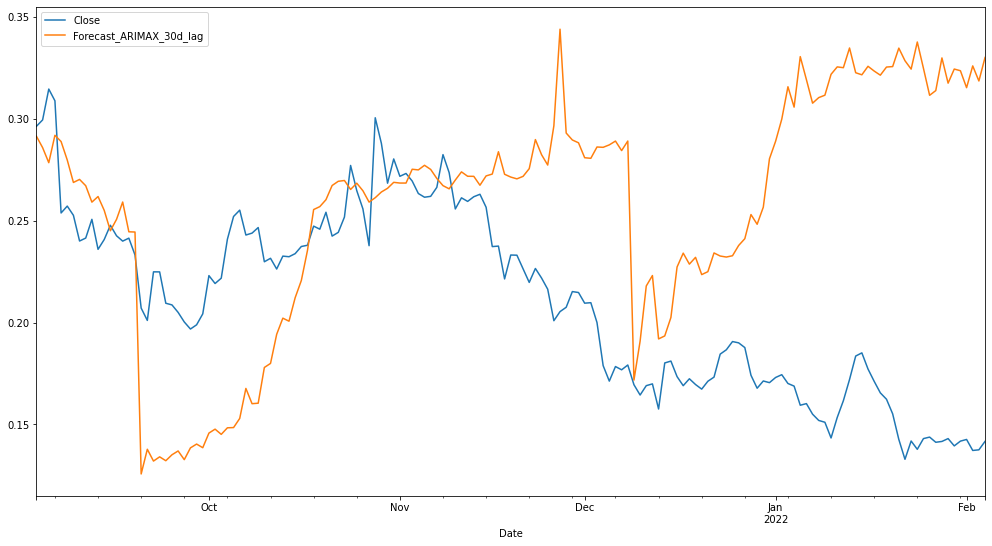

In [11]:
#Pokusavam predikciju nad lagom od 30 dana
exog_30_days = []
for feature in lag_features:
    exog_30_days.append(f"{feature}_mean_lag{window3}")
    #exog_30_days.append(f"{feature}_std_lag{window3}")

model = auto_arima(train.Close, exogenous=train[exog_30_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_30_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_30_days])
test["Forecast_ARIMAX_30d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_30d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7926.508, Time=7.97 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7224.590, Time=5.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7816.724, Time=5.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7498.923, Time=6.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1472.881, Time=4.91 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7901.131, Time=7.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7003.650, Time=7.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7911.363, Time=8.60 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7934.690, Time=8.50 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7919.335, Time=8.01 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7931.366, Time=8.81 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-7996.466, Time=10.11 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-7956.574, Time=9.46 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-7990.636, Time=10.62 sec
 ARIMA(2,0,5)(0,0,

<AxesSubplot:xlabel='Date'>

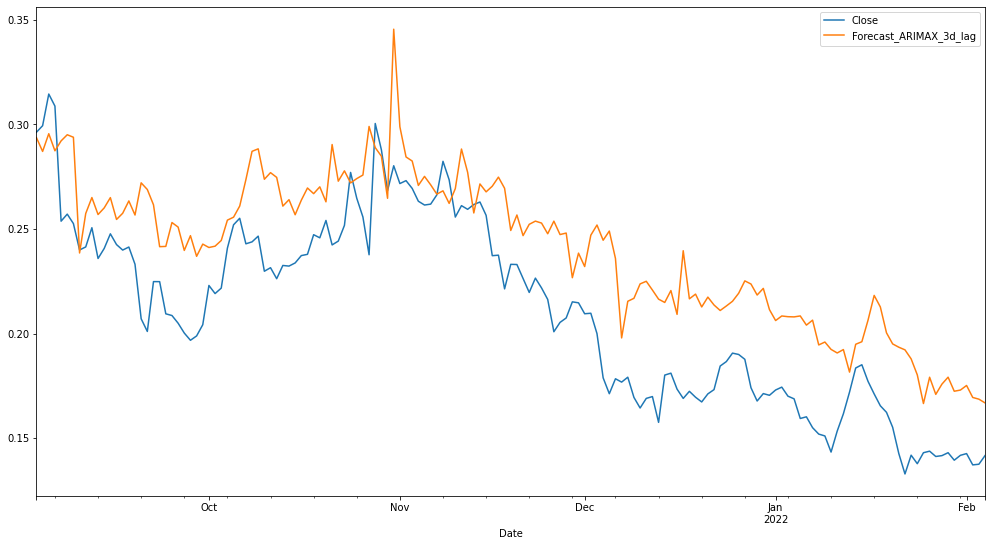

In [12]:
#Pokusavam predikciju nad lagom od 3 dana
exog_3_days = []
for feature in lag_features:
    exog_3_days.append(f"{feature}_mean_lag{window4}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_3_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_3_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_3_days])
test["Forecast_ARIMAX_3d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_3d_lag"]].plot(figsize=(17, 9))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7000.889, Time=8.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5795.078, Time=5.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6996.757, Time=5.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6436.963, Time=6.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2902.389, Time=4.93 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7002.038, Time=7.72 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6642.271, Time=7.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7003.498, Time=6.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7001.526, Time=6.63 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7002.884, Time=6.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7005.542, Time=6.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6438.959, Time=5.99 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6998.776, Time=5.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7003.638, Time=6.48 sec
 ARIMA(1,0,2)(0,0,0)

<AxesSubplot:xlabel='Date'>

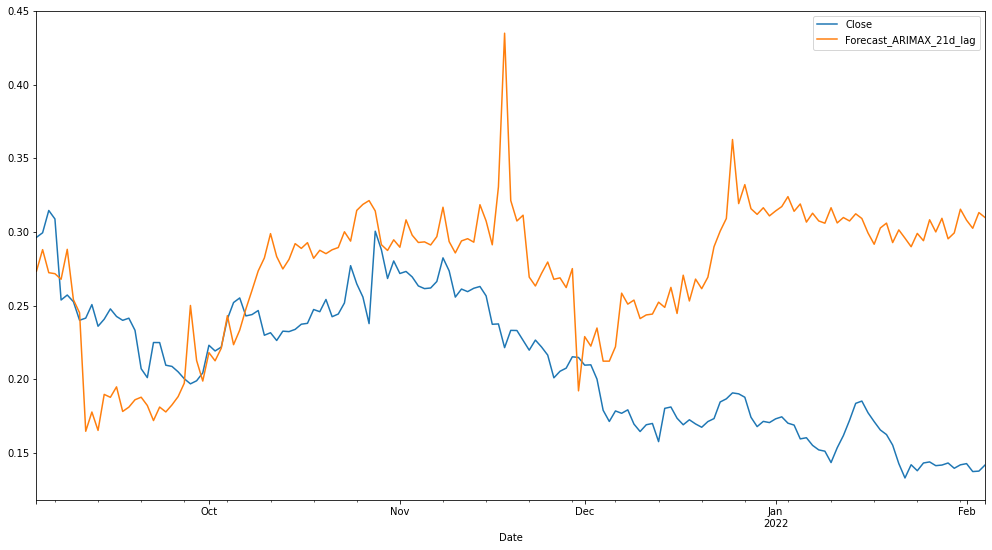

In [13]:
#Pokusavam predikciju nad lagom od 21 dana
exog_21_days = []
for feature in lag_features:
    exog_21_days.append(f"{feature}_mean_lag{window5}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_21_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_21_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_21_days])
test["Forecast_ARIMAX_21d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_21d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6546.529, Time=8.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8069.785, Time=5.84 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8098.843, Time=6.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8092.561, Time=6.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=621.067, Time=5.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8107.067, Time=7.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8117.453, Time=7.79 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-8117.094, Time=9.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8115.656, Time=8.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8062.885, Time=7.59 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-8112.730, Time=10.27 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8118.855, Time=7.47 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8108.352, Time=6.80 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-8118.535, Time=9.86 sec
 ARIMA(3,1,1)(0,0,0)

<AxesSubplot:xlabel='Date'>

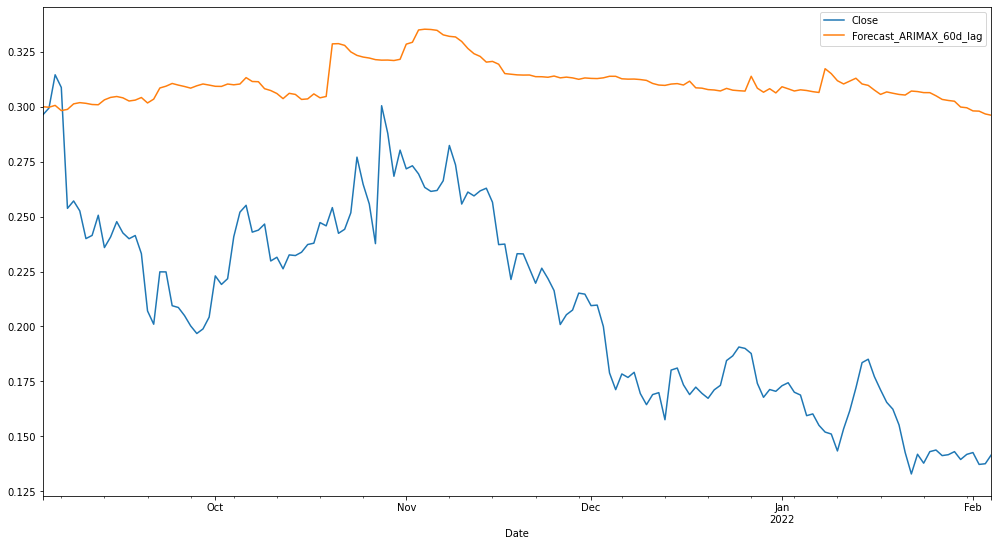

In [14]:
#Pokusavam predikciju nad lagom od 60 dana
exog_60_days = []
for feature in lag_features:
    exog_60_days.append(f"{feature}_mean_lag{window6}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_60_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_60_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_60_days])
test["Forecast_ARIMAX_60d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_60d_lag"]].plot(figsize=(17, 9))

In [15]:
def mape(actual,pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

d3_mape = mape(test.Close, test.Forecast_ARIMAX_3d_lag)
d7_mape = mape(test.Close, test.Forecast_ARIMAX_7d_lag)
d14_mape = mape(test.Close, test.Forecast_ARIMAX_14d_lag)
d30_mape = mape(test.Close, test.Forecast_ARIMAX_30d_lag)
print(f"MAPE 3D: {d3_mape}")
print(f"MAPE 7D: {d7_mape}")
print(f"MAPE 14D: {d14_mape}")
print(f"MAPE 30D: {d30_mape}")

MAPE 3D: 16.881409408278078
MAPE 7D: 24.324918505645158
MAPE 14D: 35.2992089151551
MAPE 30D: 41.66256520048002


In [16]:
exog_all = df.columns[24:]
print(exog_all)


Index(['High_mean_lag7', 'High_mean_lag14', 'High_mean_lag30',
       'High_mean_lag3', 'High_mean_lag21', 'High_mean_lag60', 'Low_mean_lag7',
       'Low_mean_lag14', 'Low_mean_lag30', 'Low_mean_lag3',
       ...
       'dogecoin_monthly_mean_lag30', 'dogecoin_monthly_mean_lag3',
       'dogecoin_monthly_mean_lag21', 'dogecoin_monthly_mean_lag60',
       'dogecoin_mean_lag7', 'dogecoin_mean_lag14', 'dogecoin_mean_lag30',
       'dogecoin_mean_lag3', 'dogecoin_mean_lag21', 'dogecoin_mean_lag60'],
      dtype='object', length=114)


In [17]:
df.drop(exog_all, 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   Open                         1549 non-null   float64       
 2   High                         1549 non-null   float64       
 3   Low                          1549 non-null   float64       
 4   Close                        1549 non-null   float64       
 5   Adj Close                    1549 non-null   float64       
 6   Volume                       1549 non-null   int64         
 7   twitter_followers            1549 non-null   float64       
 8   reddit_average_posts_48h     1549 non-null   float64       
 9   reddit_average_comments_48h  1549 non-null   float64       
 10  reddit_subscribers           1549 non-null   float64       
 11  reddit_accounts_active_48

In [18]:
# Predikcija nad dodatno prociscenim skupom doge_v2
df = pd.read_csv('../doge_v2.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()


,Date,High,Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,total_issues,dogecoin_monthly,dogecoin
Date,,,,,,,,,,
2017-11-09,2017-11-09,0.001415,0.001415,6259550,165257.000000,0.633,9.490,395.000000,1.0,0.57
2017-11-10,2017-11-10,0.001431,0.001163,4246520,165308.000000,0.833,11.958,395.166667,1.0,0.24
2017-11-11,2017-11-11,0.001257,0.001201,2231080,165363.000000,0.980,13.224,395.333333,1.0,0.23
2017-11-12,2017-11-12,0.001210,0.001038,3288960,165402.000000,1.102,14.469,395.500000,1.0,0.23
2017-11-13,2017-11-13,0.001212,0.001211,2481270,165452.666667,1.277,15.383,395.666667,1.0,0.41


In [19]:
df = df.resample('D').ffill()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Freq: D
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   High                         1549 non-null   float64       
 2   Close                        1549 non-null   float64       
 3   Volume                       1549 non-null   int64         
 4   twitter_followers            1549 non-null   float64       
 5   reddit_average_posts_48h     1549 non-null   float64       
 6   reddit_average_comments_48h  1549 non-null   float64       
 7   total_issues                 1549 non-null   float64       
 8   dogecoin_monthly             1549 non-null   float64       
 9   dogecoin                     1549 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 133.1 KB


In [20]:
from python_scripts.sarima_helper import create_lagged_value_columns

df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Volume", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "total_issues", "dogecoin_monthly", "dogecoin"]
windows = [3,7,14,21,30,60]
df = create_lagged_value_columns(lag_features, windows, df)


In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    1549 non-null   datetime64[ns]
 1   High                                    1549 non-null   float64       
 2   Close                                   1549 non-null   float64       
 3   Volume                                  1549 non-null   int64         
 4   twitter_followers                       1549 non-null   float64       
 5   reddit_average_posts_48h                1549 non-null   float64       
 6   reddit_average_comments_48h             1549 non-null   float64       
 7   total_issues                            1549 non-null   float64       
 8   dogecoin_monthly                        1549 non-null   float64       
 9   dogecoin                          

In [22]:
testNum = round(df.shape[0] * 0.3)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


In [23]:
df.isna().sum(axis = 0)


Date                                      0
High                                      0
Close                                     0
Volume                                    0
twitter_followers                         0
reddit_average_posts_48h                  0
reddit_average_comments_48h               0
total_issues                              0
dogecoin_monthly                          0
dogecoin                                  0
High_mean_lag3                            0
Volume_mean_lag3                          0
twitter_followers_mean_lag3               0
reddit_average_posts_48h_mean_lag3        0
reddit_average_comments_48h_mean_lag3     0
total_issues_mean_lag3                    0
dogecoin_monthly_mean_lag3                0
dogecoin_mean_lag3                        0
High_mean_lag7                            0
Volume_mean_lag7                          0
twitter_followers_mean_lag7               0
reddit_average_posts_48h_mean_lag7        0
reddit_average_comments_48h_mean

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11268.902, Time=3.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12185.842, Time=2.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13269.432, Time=2.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-12704.501, Time=2.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5694.230, Time=1.84 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-13285.560, Time=2.68 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-13291.628, Time=3.38 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-13294.935, Time=3.84 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-13310.196, Time=4.44 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-13299.649, Time=4.83 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-13288.447, Time=4.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-13312.496, Time=4.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-13297.130, Time=3.36 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-13301.742, Time=4.45 sec
 ARIMA

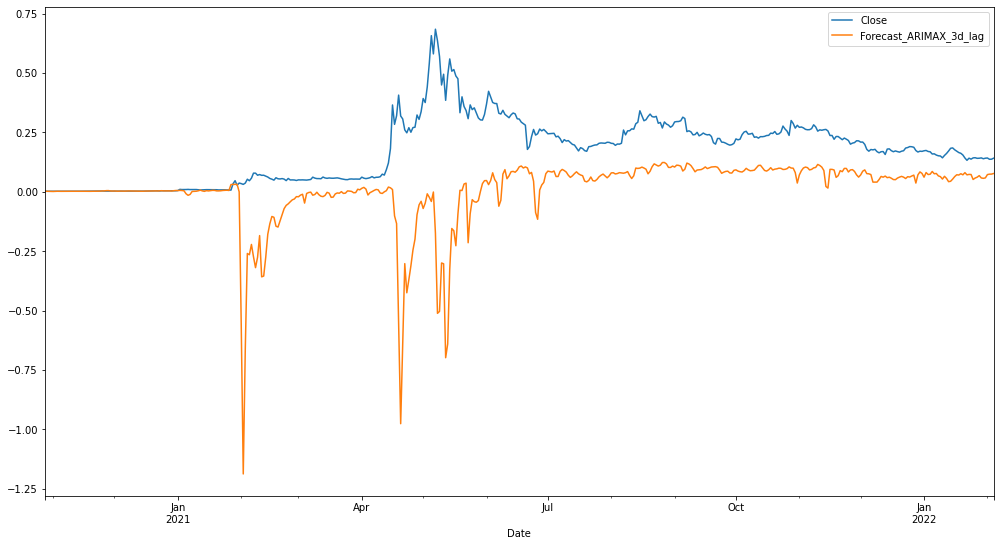

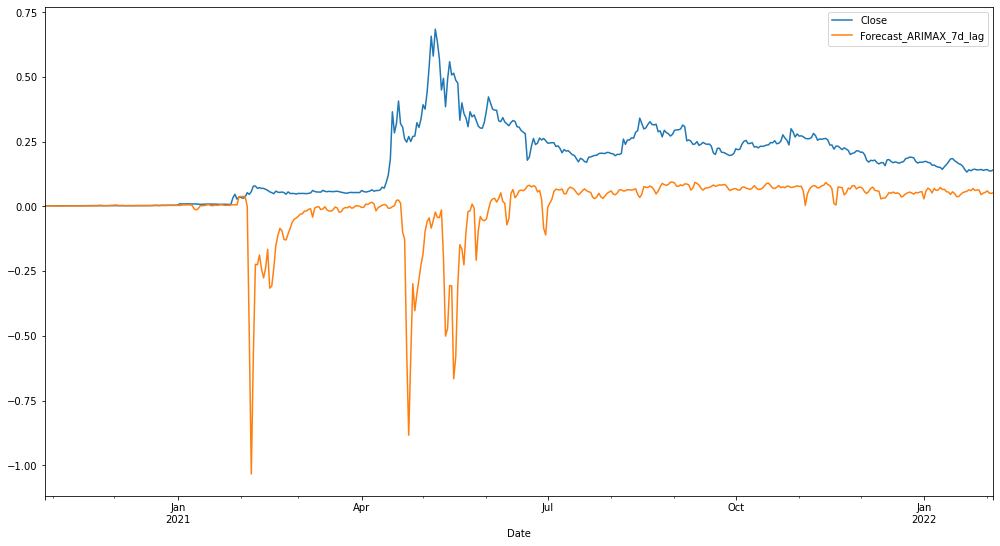

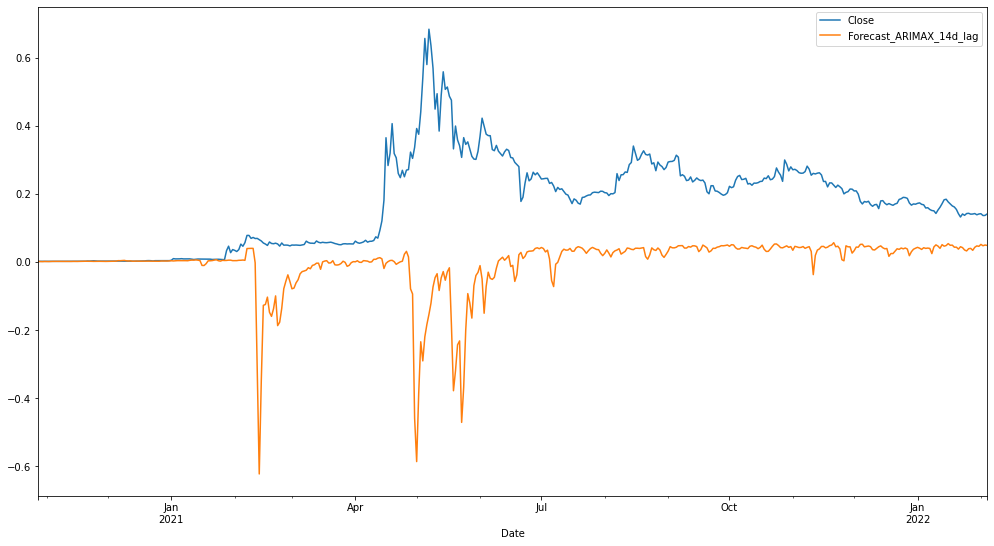

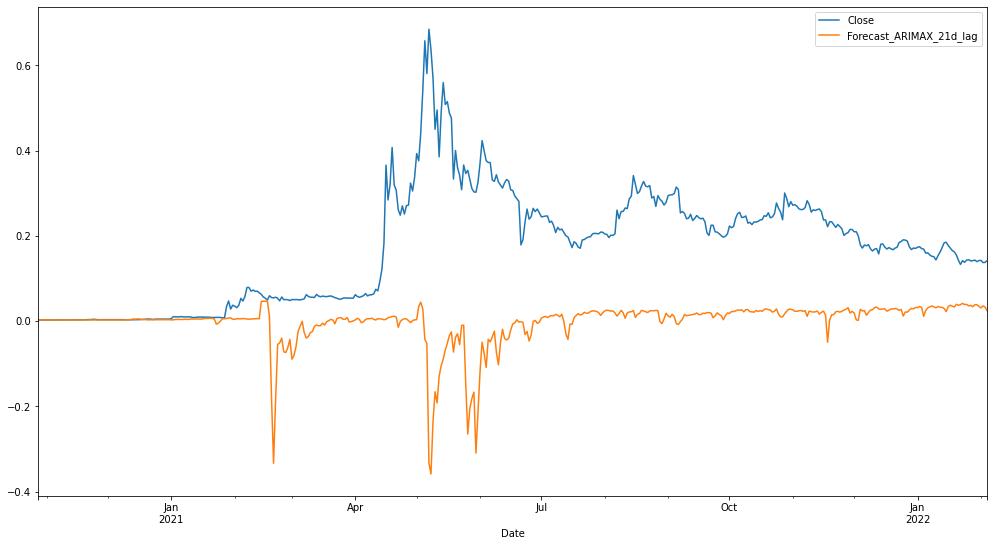

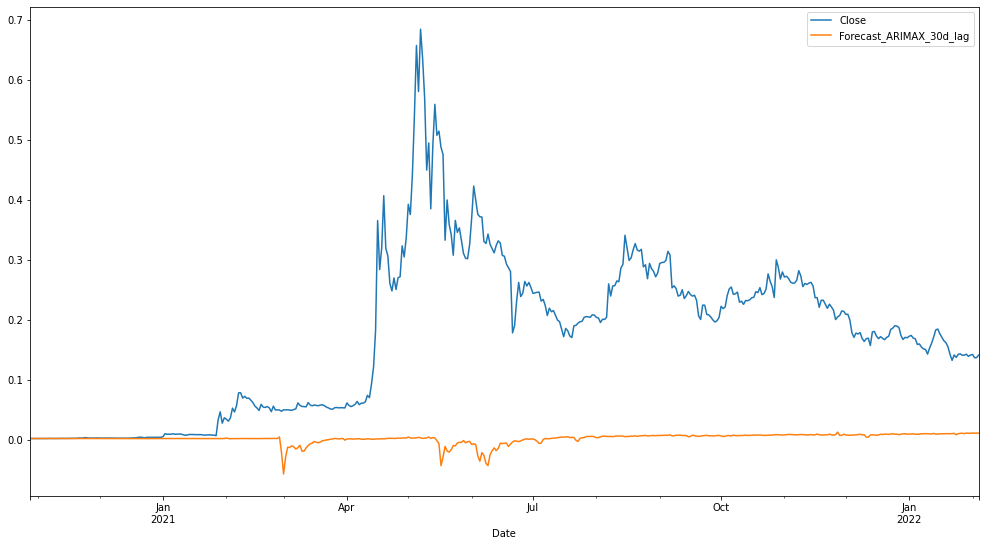

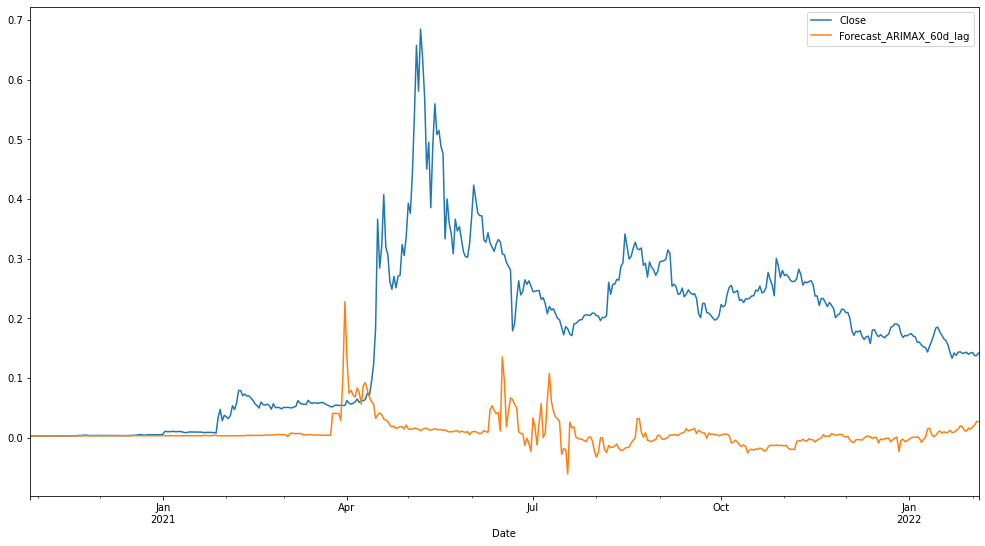

In [24]:

from python_scripts.sarima_helper import predict_with_windows

predict_with_windows(windows, train, test, lag_features)

<AxesSubplot:xlabel='Date'>

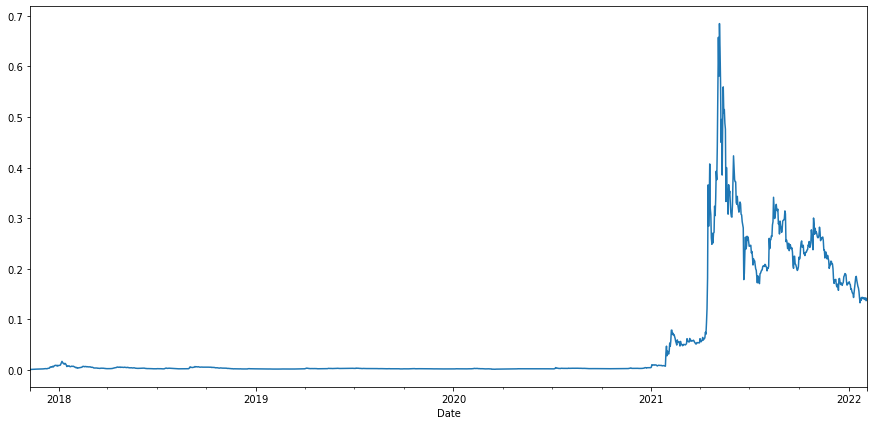

In [25]:
df.Close.plot(figsize=(15, 7))


In [26]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7836.628, Time=4.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6931.021, Time=2.65 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7832.942, Time=2.91 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7478.074, Time=3.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1769.604, Time=2.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7835.514, Time=4.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6533.468, Time=3.80 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-6632.191, Time=4.97 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7835.285, Time=4.98 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7832.063, Time=3.53 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7834.444, Time=4.65 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7832.561, Time=4.60 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-6527.139, Time=5.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7847.136, Time=4.32 sec
 ARIMA(1,0,2)(0,0,0)

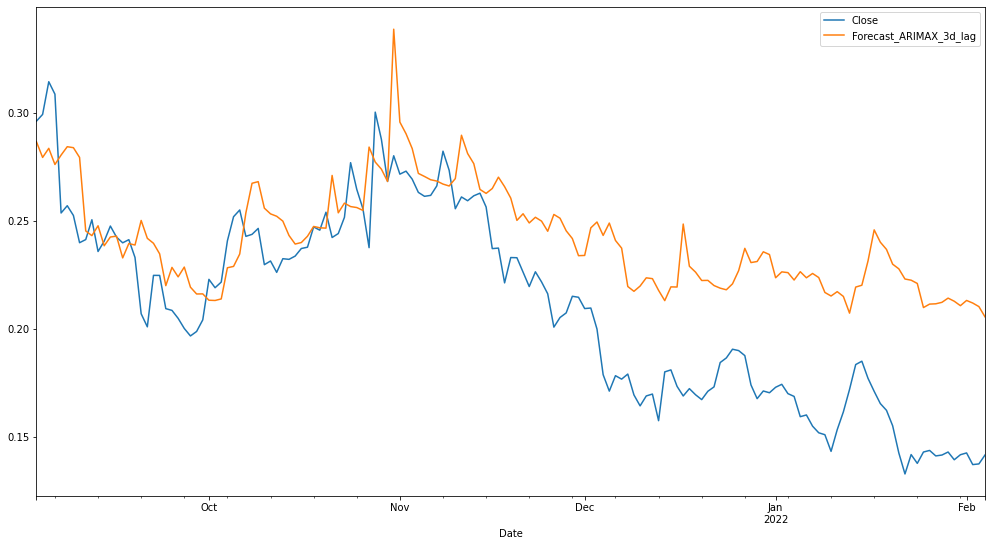

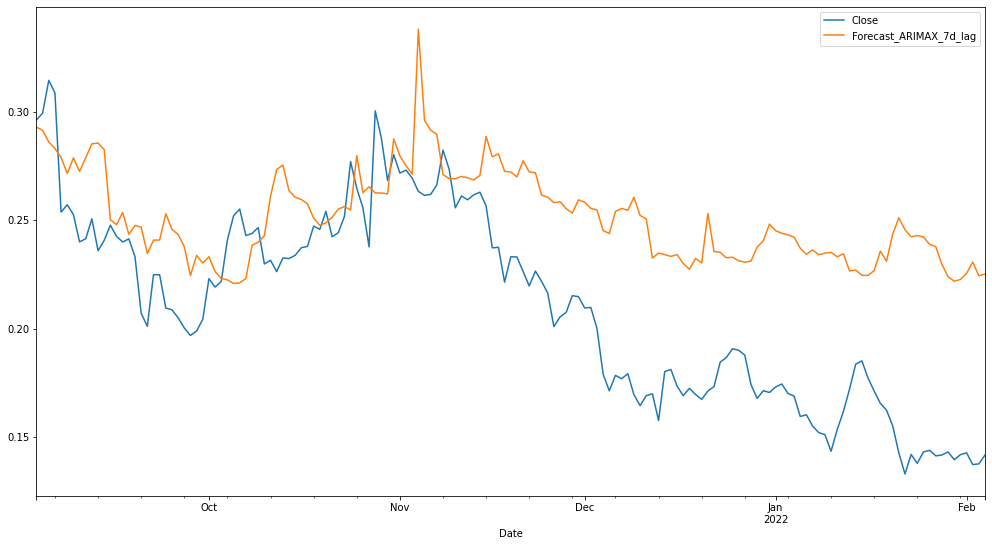

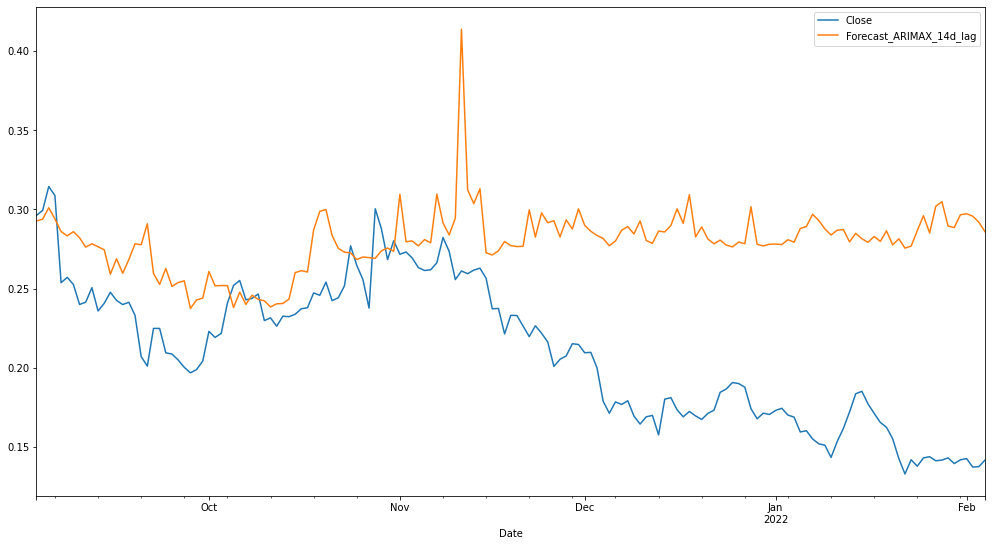

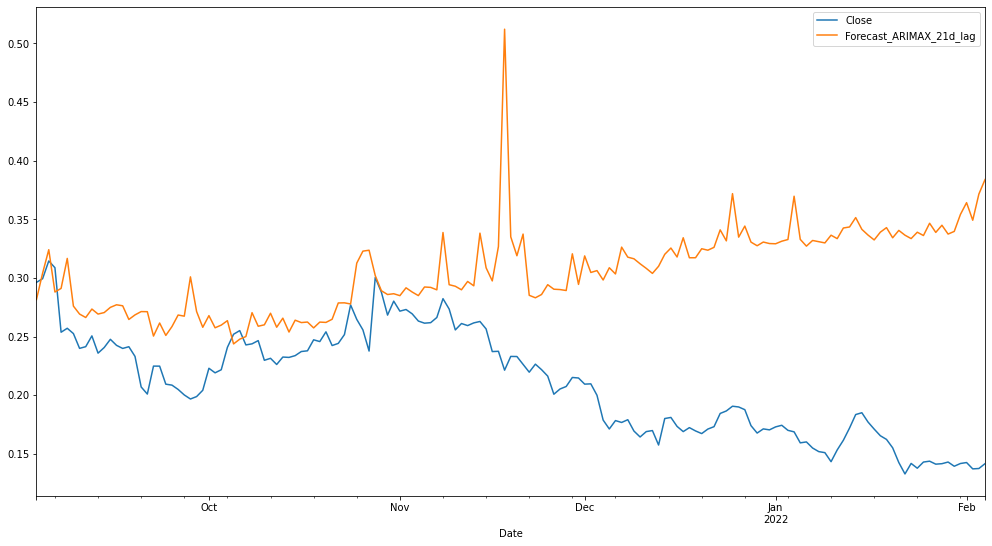

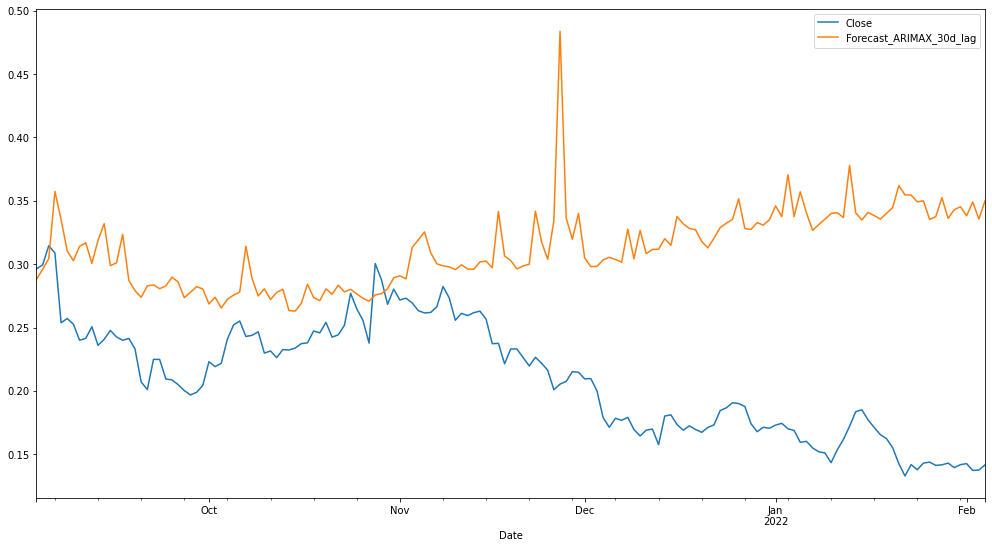

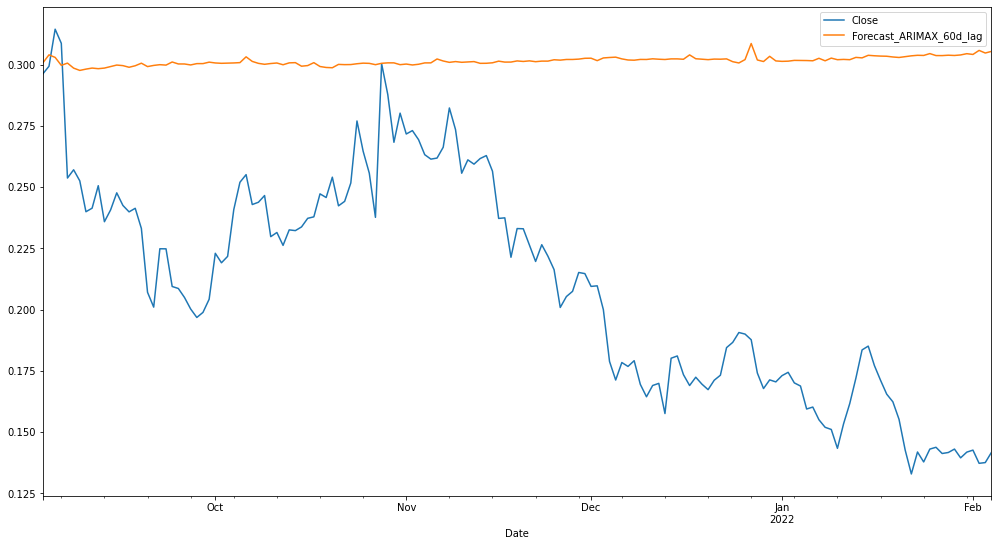

In [27]:
predict_with_windows(windows, train, test, lag_features)

In [28]:
# Korelacija za lagovane vrednosti
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [29]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
df = create_lagged_value_columns(lag_features, windows, df)
for feature in lag_features:
    del df[feature]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Columns: 119 entries, Date to dogecoin_mean_lag60
dtypes: datetime64[ns](1), float64(117), int64(1)
memory usage: 1.4 MB


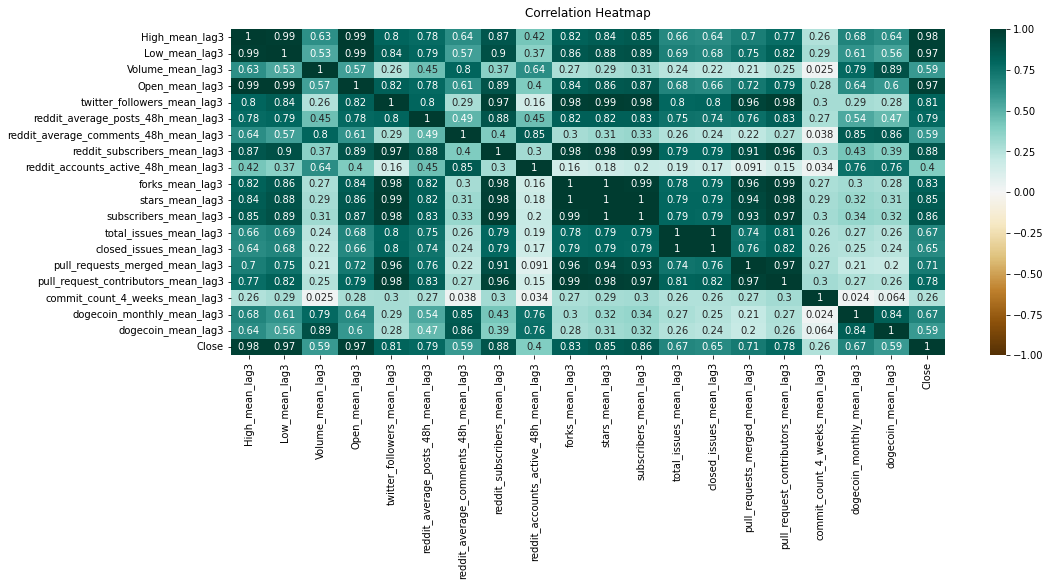

In [31]:
exogs= []
for feature in lag_features:
    exogs.append(f"{feature}_mean_lag{windows[0]}")
exogs.append('Close')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[exogs].corr(), cmap='BrBG', vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('../heatmap_doge_v3.png', dpi=300, bbox_inches='tight')


In [32]:
to_delete = ['Volume_mean_lag3', 'reddit_average_comments_48h_mean_lag3', 'reddit_accounts_active_48h_mean_lag3',
             'commit_count_4_weeks_mean_lag3', 'dogecoin_mean_lag3']
lags_remove = ['Volume', 'reddit_average_comments_48h', 'reddit_accounts_active_48h','commit_count_4_weeks',
               'dogecoin']
for lag in lags_remove:
    lag_features.remove(lag)

for feature in to_delete:
    del df[feature]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7840.414, Time=6.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6998.024, Time=4.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7676.039, Time=4.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7266.550, Time=5.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1699.447, Time=3.81 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7788.800, Time=6.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6668.646, Time=5.38 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7833.152, Time=6.73 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7842.065, Time=7.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7811.068, Time=6.56 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7837.285, Time=7.09 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-7892.282, Time=8.17 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-7867.356, Time=7.71 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-7889.906, Time=9.22 sec
 ARIMA(2,0,5)(0,0,0)

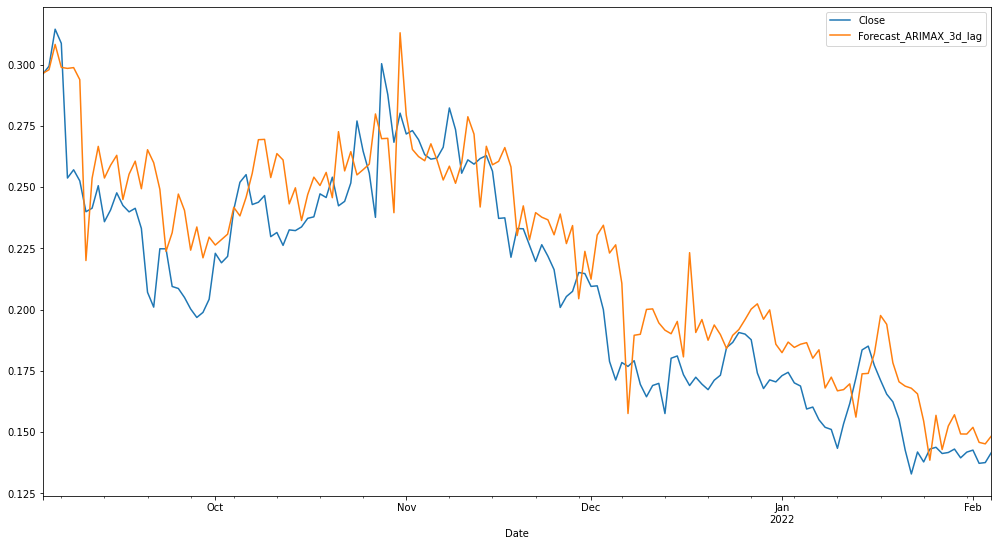

In [33]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]
predict_with_windows(windows[0:1], train, test, lag_features)


In [34]:
to_delete = ['High_mean_lag3', 'Low_mean_lag3', 'twitter_followers_mean_lag3', 'reddit_subscribers_mean_lag3',
             'forks_mean_lag3', 'stars_mean_lag3', 'subscribers_mean_lag3', 'total_issues_mean_lag3',
             'pull_requests_merged_mean_lag3']
lags_remove = ['High', 'Low', 'twitter_followers', 'reddit_subscribers', 'forks', 'stars', 'subscribers', 'total_issues',
               'pull_requests_merged']

for lag in lags_remove:
    lag_features.remove(lag)

for feature in to_delete:
    del df[feature]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7598.123, Time=55.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6381.134, Time=2.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7532.590, Time=4.91 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7195.275, Time=2.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6276.703, Time=7.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7520.484, Time=52.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5654.887, Time=3.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7666.366, Time=65.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7518.019, Time=3.81 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-7954.056, Time=12.80 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-7814.495, Time=4.03 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-7890.264, Time=7.05 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-7900.113, Time=4.69 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7261.604, Time=4.33 sec
 ARIMA(5,0,1)(0

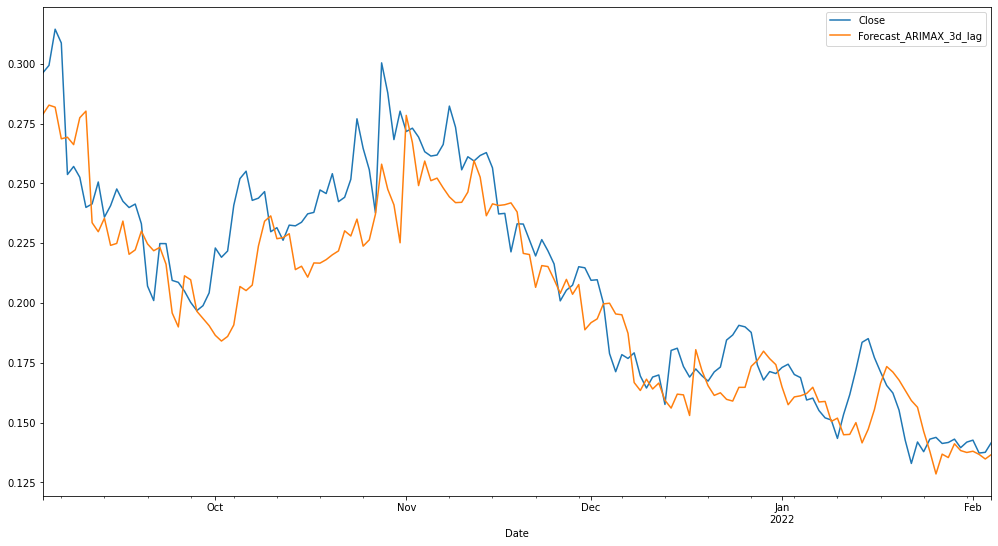

In [35]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]
predict_with_windows(windows[0:1], train, test, lag_features)

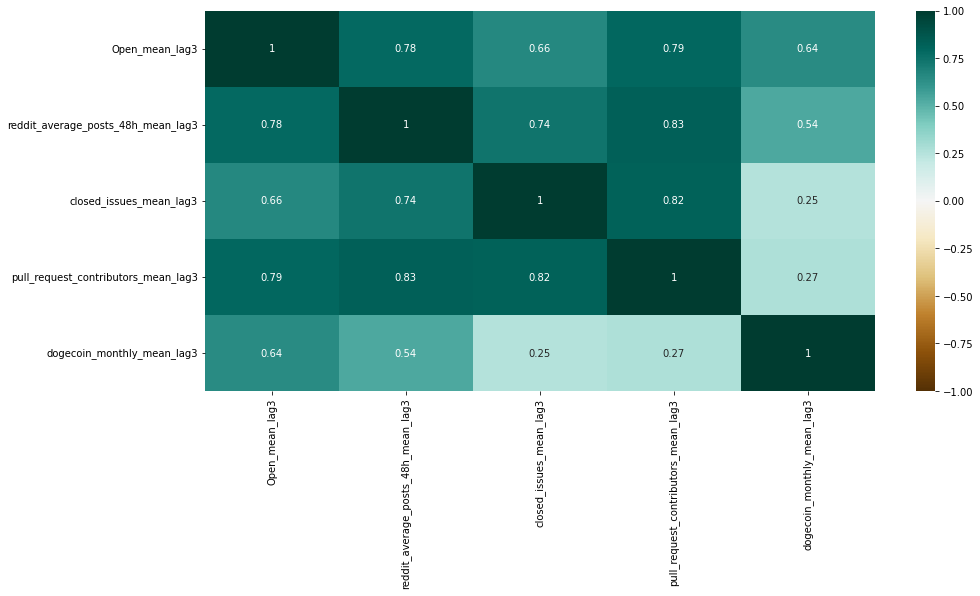

In [36]:
heatmap = sns.heatmap(df[['Open_mean_lag3', 'reddit_average_posts_48h_mean_lag3',
                      'closed_issues_mean_lag3', 'pull_request_contributors_mean_lag3',
                      'dogecoin_monthly_mean_lag3']].corr(), cmap='BrBG', vmin=-1, vmax=1, annot=True)


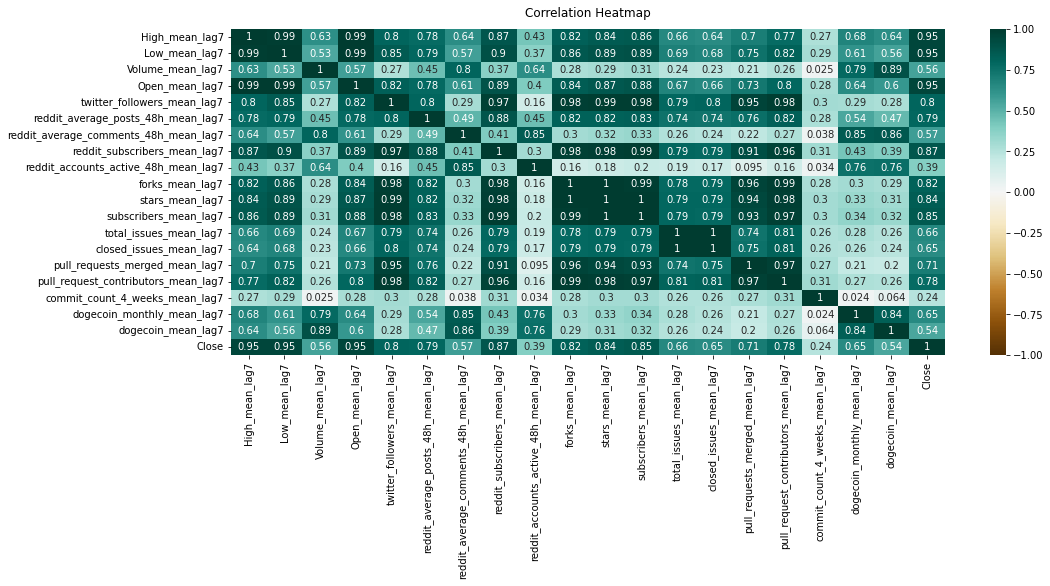

In [37]:
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
exogs= []
for feature in lag_features:
    exogs.append(f"{feature}_mean_lag{windows[1]}")
exogs.append('Close')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[exogs].corr(), cmap='BrBG', vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('../heatmap_doge_v4.png', dpi=300, bbox_inches='tight')


In [38]:
features_copy = lag_features
features_to_remove = ['Volume', 'reddit_average_comments_48h', 'reddit_accounts_active_48h', 'commit_count_4_weeks',
                      'dogecoin', 'High', 'Low', 'twitter_followers', 'reddit_subscribers', 'forks', 'stars',
                      'subscribers', 'total_issues', 'pull_requests_merged']
for feature in features_to_remove:
    del df[f"{feature}_mean_lag{windows[1]}"]
    lag_features.remove(feature)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7333.913, Time=5.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5527.752, Time=2.32 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7294.665, Time=9.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6279.686, Time=4.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5472.718, Time=8.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7387.079, Time=9.49 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5349.795, Time=7.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7325.262, Time=6.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7465.739, Time=9.58 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.93 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7474.539, Time=15.45 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7450.885, Time=16.81 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-7463.027, Time=10.43 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-7478.231, Time=11.00 sec
 ARIMA(0,0,4)(0,0,0)[

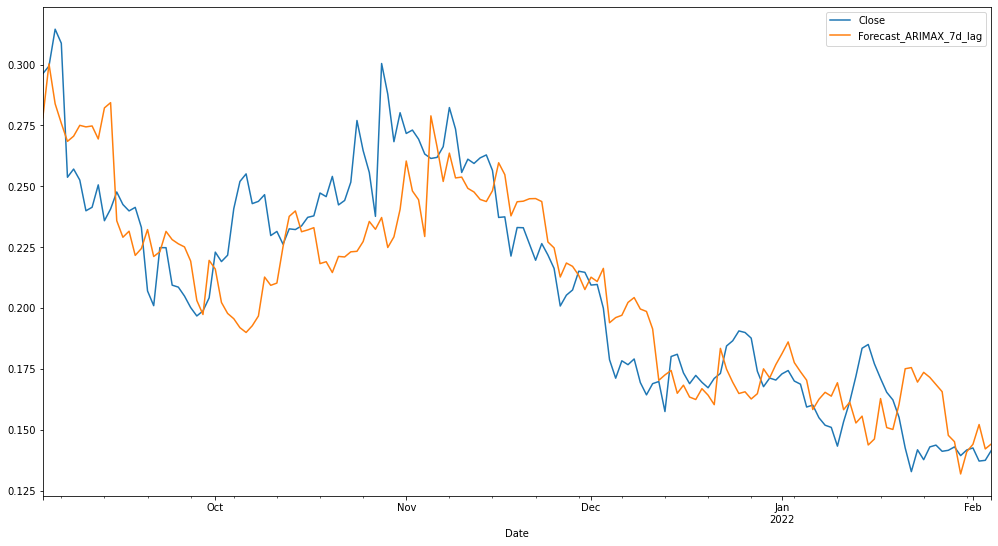

In [39]:
from python_scripts.sarima_helper import train_test_split_continual

train, test = train_test_split_continual(df, 0.1)
predict_with_windows(windows[1:2], train, test, lag_features)

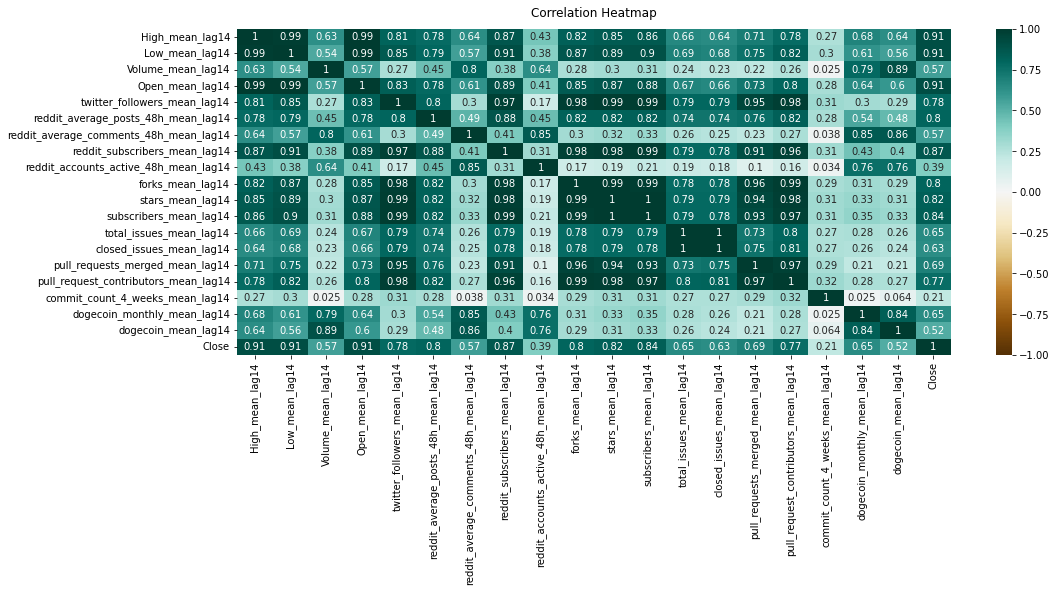

In [41]:
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
exogs= []
for feature in lag_features:
    exogs.append(f"{feature}_mean_lag{windows[2]}")
exogs.append('Close')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[exogs].corr(), cmap='BrBG', vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('../heatmap_doge_v5.png', dpi=300, bbox_inches='tight')


In [42]:
features_copy = lag_features
features_to_remove = ['Volume', 'reddit_average_comments_48h', 'reddit_accounts_active_48h', 'commit_count_4_weeks',
                      'dogecoin', 'High', 'Low', 'twitter_followers', 'reddit_subscribers', 'forks', 'stars',
                      'subscribers', 'total_issues', 'pull_requests_merged']
for feature in features_to_remove:
    del df[f"{feature}_mean_lag{windows[2]}"]
    lag_features.remove(feature)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7599.273, Time=11.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4895.261, Time=1.98 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8000.288, Time=9.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5709.530, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4856.487, Time=7.22 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7590.405, Time=5.64 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7590.513, Time=6.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4876.934, Time=43.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7901.542, Time=6.26 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 93.945 seconds
MAPE for 14 day lag prediction is 56.828649562826705


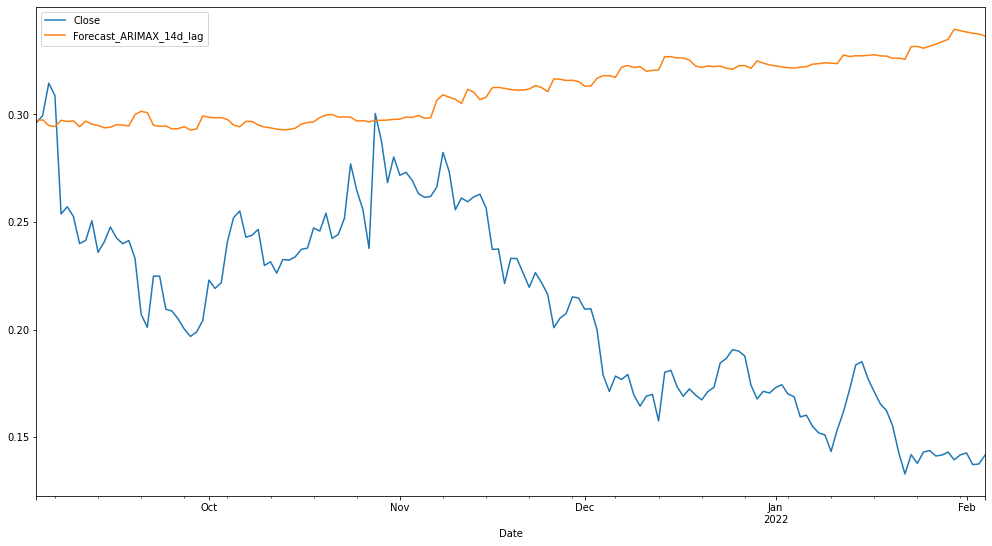

In [43]:
train, test = train_test_split_continual(df, 0.1)
predict_with_windows(windows[2:3], train, test, lag_features)
